In [2]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import pickle
import madmom
import sklearn

from tensorflow import keras
import tensorflow
from tensorflow.keras import datasets, layers, models, regularizers, optimizers, callbacks

print(tensorflow.__version__)
#參考 https://arxiv.org/pdf/1706.02921.pdf

2.4.1


In [3]:
path = "./HW1 Datasets/GTZAN/GTZAN/wav"

genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {-1:'-1', 0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

annotation_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
                          'D#', 'E', 'F', 'F#', 'G', 'G#']

annotation_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
                          'd#', 'e', 'f', 'f#', 'g', 'g#']

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']


In [4]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [5]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [6]:
analysis_path = "./temp/GTZAN_analysis_Q6/"
try:
    shutil.rmtree(analysis_path)
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

data = np.zeros((837,144,150))
target = np.zeros((837))

for root, dirs, files in os.walk(path):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".wav")):
            # print("============")
            # print("sorted_name", name)
            txt_file_path = name.replace(".wav", ".lerch.txt")
            txt_file_path = txt_file_path.replace("wav", "key")
            name_split = txt_file_path.split('.')
            #print(name_split)
            #print("txt_file_path = ", txt_file_path)
            genre = txt_file_path.split(".")[0]
            binary_file_num_dict[genre] += 1
            y, sr = librosa.load(
                r"./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name, sr = 22050, mono = True, dtype = np.float32) #duration setting
            audio = librosa.effects.pitch_shift(y, sr, n_steps=1)
            hybrid_cqt_series = librosa.core.hybrid_cqt(y, sr=sr, bins_per_octave=24, n_bins=144, hop_length=int(sr / 5))
            #print(hybrid_cqt_series.shape)
            
            f_ground_truth = open(str("./HW1 Datasets/GTZAN/GTZAN/key/" + genre + "/" + txt_file_path),"r")
            #fc #moving_scale
            key_gt = moving_scale[int(f_ground_truth.readline().rstrip())]
            #print(key_gt)

            data[index]=hybrid_cqt_series[:,:150]
            target[index]=int(key_gt)
            
            filename = "./temp/GTZAN_analysis_Q6/hybrid_cqt_chroma/hybrid_cqt." + name_split[0]+ "." + name_split[1] + "." + key_gt + ".txt"
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'w') as f:
                np.savetxt(filename, hybrid_cqt_series)

/tmp/ipykernel_914385/1586532491.py:27: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.pitch_shift(y, sr, n_steps=1)
/tmp/ipykernel_914385/1586532491.py:27: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio = librosa.effects.pitch_shift(y, sr, n_steps=1)


In [7]:
data = np.zeros((837,144,150))
target = np.zeros((837))

for root, dirs, files in os.walk(path):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".wav")):
            # print("============")
            # print("sorted_name", name)
            txt_file_path = name.replace(".wav", ".lerch.txt")
            txt_file_path = txt_file_path.replace("wav", "key")
            name_split = txt_file_path.split('.')
            #print("txt_file_path = ", txt_file_path)
            genre = txt_file_path.split(".")[0]
            binary_file_num_dict[genre] += 1

            dcp = madmom.audio.chroma.DeepChromaProcessor()
            chroma = dcp("./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name)
            chroma = chroma[:300,:]
            if chroma.shape[0] != 300:
                print("Error")
                print(chroma.shape[0])

            f_ground_truth = open(str("./HW1 Datasets/GTZAN/GTZAN/key/" + genre + "/" + txt_file_path),"r")
            #fc #moving_scale
            key_gt = moving_scale[int(f_ground_truth.readline().rstrip())]
            #print(key_gt)

            filename = os.path.split(name)[1]
            filename = os.path.splitext(filename)[0]
            filename = "./temp/GTZAN_analysis_Q6/deep_chroma/hybrid_cqt." + name_split[0]+ "." + name_split[1] + "." + key_gt + ".csv"
            #print(filename)
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'a+') as f:
                np.savetxt(filename, chroma)


In [8]:
deep_chroma_list = []
for root, dirs, files in os.walk("./temp/GTZAN_analysis_Q6/deep_chroma/"):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".csv")):
            deep_chroma_list.append(name)

deep_chroma_list

deep_chroma_list_unknown = list(filter(lambda x: "-1" in x, deep_chroma_list))

In [9]:
for item in deep_chroma_list_unknown:
    deep_chroma_list.remove(item)

In [10]:
deep_chroma_list

['hybrid_cqt.blues.00000.13.csv',
 'hybrid_cqt.blues.00001.10.csv',
 'hybrid_cqt.blues.00002.10.csv',
 'hybrid_cqt.blues.00003.10.csv',
 'hybrid_cqt.blues.00004.4.csv',
 'hybrid_cqt.blues.00005.12.csv',
 'hybrid_cqt.blues.00006.11.csv',
 'hybrid_cqt.blues.00007.4.csv',
 'hybrid_cqt.blues.00008.10.csv',
 'hybrid_cqt.blues.00009.13.csv',
 'hybrid_cqt.blues.00010.11.csv',
 'hybrid_cqt.blues.00011.10.csv',
 'hybrid_cqt.blues.00012.5.csv',
 'hybrid_cqt.blues.00013.4.csv',
 'hybrid_cqt.blues.00014.4.csv',
 'hybrid_cqt.blues.00015.4.csv',
 'hybrid_cqt.blues.00016.3.csv',
 'hybrid_cqt.blues.00017.3.csv',
 'hybrid_cqt.blues.00018.4.csv',
 'hybrid_cqt.blues.00019.3.csv',
 'hybrid_cqt.blues.00020.10.csv',
 'hybrid_cqt.blues.00021.11.csv',
 'hybrid_cqt.blues.00022.11.csv',
 'hybrid_cqt.blues.00023.3.csv',
 'hybrid_cqt.blues.00024.4.csv',
 'hybrid_cqt.blues.00025.4.csv',
 'hybrid_cqt.blues.00026.4.csv',
 'hybrid_cqt.blues.00027.4.csv',
 'hybrid_cqt.blues.00028.4.csv',
 'hybrid_cqt.blues.00029.8.csv

In [11]:
len(deep_chroma_list)

837

In [12]:
deep_chroma_list[0].split('.')[3]

'13'

In [14]:
N = len(deep_chroma_list)

dataset = np.zeros((N,300,12))
target  = np.zeros((N))

for i in range(0, N):
    target[i] = deep_chroma_list[i].split('.')[3]
    print("target[i]: ", target[i])
    data = np.loadtxt("./temp/GTZAN_analysis_Q6/deep_chroma/" + deep_chroma_list[i])
        #print(data.shape)
    data = data[:300,:]
    dataset[i,:,:] = data

print(data)
print(dataset.shape)
print(target.shape)

with open("./temp/GTZAN_analysis_Q6/input.pkl", "wb") as f:
    pickle.dump(dataset, f)

with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
    x = pickle.load(f)

print(x.shape)

with open("./temp/GTZAN_analysis_Q6/output.pkl", "wb") as f:
    pickle.dump(target, f)
    
with open("./temp/GTZAN_analysis_Q6/output.pkl", "rb") as f:
    x = pickle.load(f)

print(x.shape)

target[i]:  13.0
target[i]:  10.0
target[i]:  10.0
target[i]:  10.0
target[i]:  4.0
target[i]:  12.0
target[i]:  11.0
target[i]:  4.0
target[i]:  10.0
target[i]:  13.0
target[i]:  11.0
target[i]:  10.0
target[i]:  5.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  3.0
target[i]:  3.0
target[i]:  4.0
target[i]:  3.0
target[i]:  10.0
target[i]:  11.0
target[i]:  11.0
target[i]:  3.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  8.0
target[i]:  6.0
target[i]:  8.0
target[i]:  6.0
target[i]:  11.0
target[i]:  8.0
target[i]:  16.0
target[i]:  11.0
target[i]:  11.0
target[i]:  8.0
target[i]:  11.0
target[i]:  2.0
target[i]:  10.0
target[i]:  13.0
target[i]:  5.0
target[i]:  9.0
target[i]:  9.0
target[i]:  9.0
target[i]:  7.0
target[i]:  9.0
target[i]:  9.0
target[i]:  5.0
target[i]:  10.0
target[i]:  13.0
target[i]:  14.0
target[i]:  3.0
target[i]:  13.0
target[i]:  10.0
target[i]:  5.0
target[i]:  13.0
target[i]:  13.0
target[i]:  3

In [15]:
with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
    dataset = pickle.load(f)

with open("./temp/GTZAN_analysis_Q6/output.pkl","rb") as f:
    target = pickle.load(f)
  

print(len(dataset))
p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

print(dataset.shape)
print(target.shape)

print(dataset.shape)
dataset = np.mean(dataset,1)
print(dataset.shape)

837
(837, 300, 12)
(837,)
(837, 300, 12)
(837, 12)


In [25]:
model = models.Sequential()

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='elu'))
model.add(layers.Dense(128, activation='elu'))
model.add(layers.Dense(48, activation='elu'))
model.add(layers.Dense(24, activation='softmax'))

x = np.zeros((1,12))
y = np.zeros((1))

sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

x_train = np.roll(dataset, 1, axis=1)
y_train = target + 1

y_train[y_train == 12] = 0
y_train[y_train == 24] = 12

x_train_1 = np.roll(dataset, 2, axis=1)
y_train_1 = target + 2

y_train_1[y_train_1 == 13] = 1
y_train_1[y_train_1 == 25] = 13
y_train_1[y_train_1 == 12] = 0
y_train_1[y_train_1 == 24] = 12

x = np.concatenate((x,x_train),0)
y = np.concatenate((y,y_train),0)

x = x[1:]
y = y[1:]
  
print("\nTraining")
n = 668

acc_history = {}

for j in range(0, 50):
  model.fit(np.concatenate((dataset[:n],x_train, x_train_1)),  np.concatenate((target[:n],y_train, y_train_1,)) , epochs=10, verbose=0)
  model.fit(np.concatenate((x_train, x_train_1)),  np.concatenate((y_train, y_train_1,)) , epochs=10, verbose=0)

  print("\nModel Trained, Evaluation: \n")
  loss, acc = model.evaluate(dataset[n+1:], target[n+1:], verbose=2)
  
  y = model.predict(dataset[n+1:])
  gt = target[n+1:]
  weighted_score = 0
  score = 0

  print(n)
  m = 168
  for i in range(0,m):
    prediction = np.argmax(y[i])
    ground_truth = gt[i]
    if prediction == ground_truth :
      score += 1
      weighted_score = weighted_score+1	
    elif (prediction + 7) % 12 == ground_truth:
      weighted_score += 0.5
    elif prediction < 12:
        if prediction + 9 == ground_truth:
            weighted_score += 0.3 # relative Major
        elif prediction + 12 == ground_truth:
            weighted_score += 0.2 # parallel Major
    elif prediction >= 12:
        if (prediction + 3) % 12 == ground_truth:
            weighted_score += 0.3 # relative minor
        elif prediction - 12 == ground_truth:
            weighted_score += 0.2 # parallel minor

  acc_history[j] = {"loss":loss, "acc":acc, "raw_acc":score/m, "weighted_acc":weighted_score/m}
  print("Weighted Score")
  print(weighted_score/m)	


Training

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.7359 - accuracy: 0.4583
668
Weighted Score
0.5202380952380954

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4581 - accuracy: 0.5298
668
Weighted Score
0.5970238095238098

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4548 - accuracy: 0.5060
668
Weighted Score
0.5714285714285717

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4419 - accuracy: 0.5357
668
Weighted Score
0.5970238095238098

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4324 - accuracy: 0.5595
668
Weighted Score
0.6196428571428575

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4287 - accuracy: 0.5238
668
Weighted Score
0.585714285714286

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4371 - accuracy: 0.5357
668
Weighted Score
0.5952380952380956

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4444 - accuracy: 0.5060
668
Weighted Score
0.579761904761905

Model Trained, Evaluation: 

6/6 - 0s - loss: 1.4343 - accuracy: 0.5298
668
Weighted Score
0.5994047619

In [29]:
acc_history

{0: {'loss': 1.7359070777893066,
  'acc': 0.4583333432674408,
  'raw_acc': 0.4583333333333333,
  'weighted_acc': 0.5202380952380954},
 1: {'loss': 1.4581319093704224,
  'acc': 0.5297619104385376,
  'raw_acc': 0.5297619047619048,
  'weighted_acc': 0.5970238095238098},
 2: {'loss': 1.4547916650772095,
  'acc': 0.5059523582458496,
  'raw_acc': 0.5059523809523809,
  'weighted_acc': 0.5714285714285717},
 3: {'loss': 1.4419481754302979,
  'acc': 0.5357142686843872,
  'raw_acc': 0.5357142857142857,
  'weighted_acc': 0.5970238095238098},
 4: {'loss': 1.4324109554290771,
  'acc': 0.5595238208770752,
  'raw_acc': 0.5595238095238095,
  'weighted_acc': 0.6196428571428575},
 5: {'loss': 1.4286600351333618,
  'acc': 0.523809552192688,
  'raw_acc': 0.5238095238095238,
  'weighted_acc': 0.585714285714286},
 6: {'loss': 1.4371182918548584,
  'acc': 0.5357142686843872,
  'raw_acc': 0.5357142857142857,
  'weighted_acc': 0.5952380952380956},
 7: {'loss': 1.444399356842041,
  'acc': 0.5059523582458496,
  '

In [30]:
acc_history_df = pd.DataFrame.from_dict({(i): acc_history[i]
                            for i in acc_history.keys()
                            }, orient='columns').T

acc_history_df.reset_index(inplace=True)
acc_history_df.columns = ['epoch', 'training_loss','training_accuracy', 'training_raw_accuracy', 'training_weighted_accuracy']
print(acc_history_df)
print(tabulate(acc_history_df, headers='keys', tablefmt='fancy_grid'))

    epoch  training_loss  training_accuracy  training_raw_accuracy  \
0       0       1.735907           0.458333               0.458333   
1       1       1.458132           0.529762               0.529762   
2       2       1.454792           0.505952               0.505952   
3       3       1.441948           0.535714               0.535714   
4       4       1.432411           0.559524               0.559524   
5       5       1.428660           0.523810               0.523810   
6       6       1.437118           0.535714               0.535714   
7       7       1.444399           0.505952               0.505952   
8       8       1.434269           0.529762               0.529762   
9       9       1.445657           0.517857               0.517857   
10     10       1.432718           0.541667               0.541667   
11     11       1.431002           0.547619               0.547619   
12     12       1.456806           0.529762               0.529762   
13     13       1.44

<AxesSubplot:>

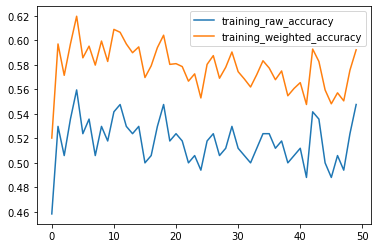

In [32]:
acc_history_df[['training_raw_accuracy', 'training_weighted_accuracy']].plot()

In [40]:
acc_history_df_mean = acc_history_df[['training_raw_accuracy', 'training_weighted_accuracy']].mean()
acc_history_df_mean

training_raw_accuracy         0.517143
training_weighted_accuracy    0.577952
dtype: float64

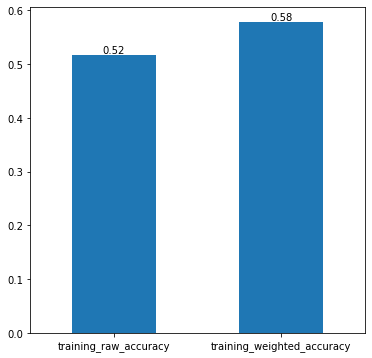

In [45]:
ax = acc_history_df_mean.plot(kind='bar', figsize=(6, 6), rot=0)
for bar_plot in ax.patches:
    ax.annotate(np.round(bar_plot.get_height(), decimals=2), (bar_plot.get_x() + bar_plot.get_width() / 2.0, bar_plot.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', )

In [33]:
hybrid_cqt_list = [item.replace('csv', 'txt') for item in deep_chroma_list]

In [34]:
hybrid_cqt_list

['hybrid_cqt.blues.00000.13.txt',
 'hybrid_cqt.blues.00001.10.txt',
 'hybrid_cqt.blues.00002.10.txt',
 'hybrid_cqt.blues.00003.10.txt',
 'hybrid_cqt.blues.00004.4.txt',
 'hybrid_cqt.blues.00005.12.txt',
 'hybrid_cqt.blues.00006.11.txt',
 'hybrid_cqt.blues.00007.4.txt',
 'hybrid_cqt.blues.00008.10.txt',
 'hybrid_cqt.blues.00009.13.txt',
 'hybrid_cqt.blues.00010.11.txt',
 'hybrid_cqt.blues.00011.10.txt',
 'hybrid_cqt.blues.00012.5.txt',
 'hybrid_cqt.blues.00013.4.txt',
 'hybrid_cqt.blues.00014.4.txt',
 'hybrid_cqt.blues.00015.4.txt',
 'hybrid_cqt.blues.00016.3.txt',
 'hybrid_cqt.blues.00017.3.txt',
 'hybrid_cqt.blues.00018.4.txt',
 'hybrid_cqt.blues.00019.3.txt',
 'hybrid_cqt.blues.00020.10.txt',
 'hybrid_cqt.blues.00021.11.txt',
 'hybrid_cqt.blues.00022.11.txt',
 'hybrid_cqt.blues.00023.3.txt',
 'hybrid_cqt.blues.00024.4.txt',
 'hybrid_cqt.blues.00025.4.txt',
 'hybrid_cqt.blues.00026.4.txt',
 'hybrid_cqt.blues.00027.4.txt',
 'hybrid_cqt.blues.00028.4.txt',
 'hybrid_cqt.blues.00029.8.txt

In [22]:
N = len(deep_chroma_list)

dataset = np.zeros((N,300,12))
target  = np.zeros((N))

for i in range(0, N):
  target[i] = deep_chroma_list[i].split('.')[3]
  print("target[i]: ", target[i])
  data = np.loadtxt("./temp/GTZAN_analysis_Q6/deep_chroma/" + deep_chroma_list[i])
	#print(data.shape)
  data = data[:300,:]
  dataset[i,:,:] = data

print(data)
print(dataset.shape)
print(target.shape)


with open("./temp/GTZAN_analysis_Q6/input.pkl", "wb") as f:
  pickle.dump(dataset, f)

with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  x = pickle.load(f)

print(x.shape)

with open("./temp/GTZAN_analysis_Q6/output.pkl", "wb") as f:
  pickle.dump(target, f)
    
with open("./temp/GTZAN_analysis_Q6/output.pkl", "rb") as f:
  x = pickle.load(f)

print(x.shape)

target[i]:  13.0
target[i]:  10.0
target[i]:  10.0
target[i]:  10.0
target[i]:  4.0
target[i]:  12.0
target[i]:  11.0
target[i]:  4.0
target[i]:  10.0
target[i]:  13.0
target[i]:  11.0
target[i]:  10.0
target[i]:  5.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  3.0
target[i]:  3.0
target[i]:  4.0
target[i]:  3.0
target[i]:  10.0
target[i]:  11.0
target[i]:  11.0
target[i]:  3.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  8.0
target[i]:  6.0
target[i]:  8.0
target[i]:  6.0
target[i]:  11.0
target[i]:  8.0
target[i]:  16.0
target[i]:  11.0
target[i]:  11.0
target[i]:  8.0
target[i]:  11.0
target[i]:  2.0
target[i]:  10.0
target[i]:  13.0
target[i]:  5.0
target[i]:  9.0
target[i]:  9.0
target[i]:  9.0
target[i]:  7.0
target[i]:  9.0
target[i]:  9.0
target[i]:  5.0
target[i]:  10.0
target[i]:  13.0
target[i]:  14.0
target[i]:  3.0
target[i]:  13.0
target[i]:  10.0
target[i]:  5.0
target[i]:  13.0
target[i]:  13.0
target[i]:  3

In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals


n = 669

p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

N = len(target)
dataset = np.expand_dims(dataset,axis=-1)
print(N)		
print(dataset.shape)
print(target.shape)

837
(837, 300, 12, 1)
(837,)


2022-04-28 00:59:56.104650: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-28 00:59:56.104801: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 00:59:56.105320: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-28 00:59:56.199390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-28 00:59:56.218213: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3693310000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 12, 24)       624       
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 12, 24)       96        
_________________________________________________________________
dropout (Dropout)            (None, 300, 12, 24)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 12, 24)       14424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 12, 24)       96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 300, 12, 24)       14424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 300, 12, 24)       9

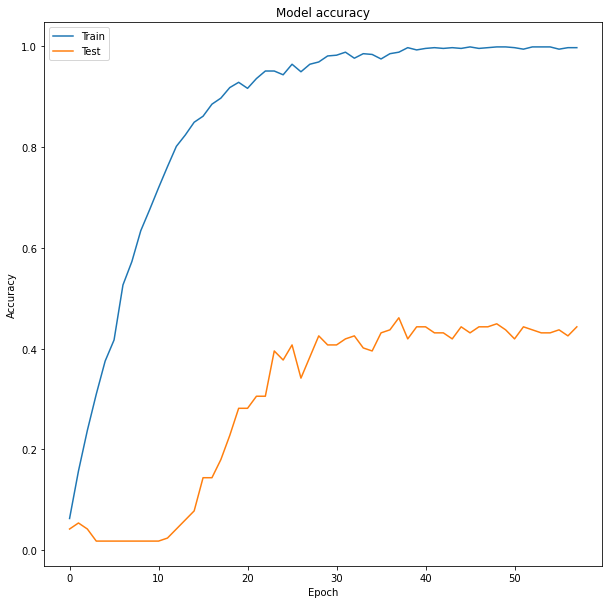

6/6 - 1s - loss: 2.3609 - accuracy: 0.4611


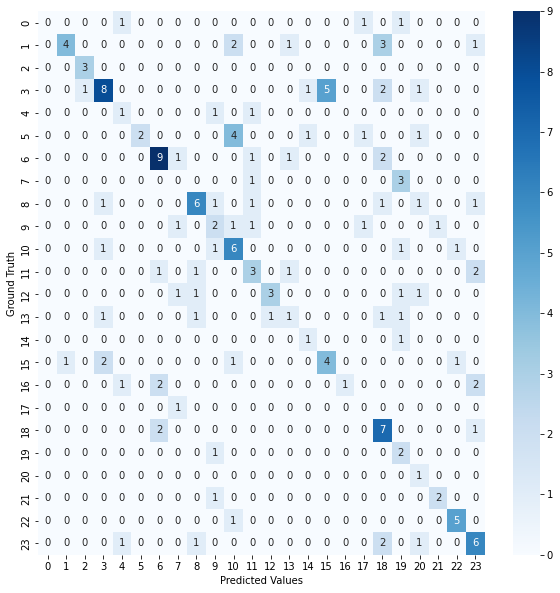


Evaluation accuracy: 46.11 % - loss: 2.36


In [24]:
model = models.Sequential()
model.add(layers.Conv2D(24, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same', input_shape=(300,12,1)))# input_shape=(144,150,1)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.AveragePooling2D(pool_size = (1,12)))
model.add(layers.Flatten())

model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining")

callback = [callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) , callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
#callback_lr = [callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
	  
history = model.fit(dataset[:n,:,:], target[:n], epochs=100,verbose=1,validation_data = (dataset[n+1:,:,:], target[n+1:]),callbacks=callback)

print("\nModel Trained, Evaluation: \n")
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(dataset[n+1:,:,:], target[n+1:], verbose=2)

if True:
  y_pred = model.predict(dataset[n+1:,:,:])
  matrix = sklearn.metrics.confusion_matrix(keras.utils.to_categorical(target[n+1:]).argmax(axis=1), y_pred.argmax(axis=1))
  figure = plt.figure(figsize=(10, 10))
  import seaborn as sns
  sns.heatmap(matrix, annot=True, cmap = plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('Ground Truth')
  plt.show()

print('\nEvaluation accuracy: %.2f %% - loss: %.2f' % (acc*100, loss))


# hybrid cqt

In [25]:
hybrid_cqt_list = [item.replace('csv', 'txt') for item in deep_chroma_list]
hybrid_cqt_list

['hybrid_cqt.blues.00000.13.txt',
 'hybrid_cqt.blues.00001.10.txt',
 'hybrid_cqt.blues.00002.10.txt',
 'hybrid_cqt.blues.00003.10.txt',
 'hybrid_cqt.blues.00004.4.txt',
 'hybrid_cqt.blues.00005.12.txt',
 'hybrid_cqt.blues.00006.11.txt',
 'hybrid_cqt.blues.00007.4.txt',
 'hybrid_cqt.blues.00008.10.txt',
 'hybrid_cqt.blues.00009.13.txt',
 'hybrid_cqt.blues.00010.11.txt',
 'hybrid_cqt.blues.00011.10.txt',
 'hybrid_cqt.blues.00012.5.txt',
 'hybrid_cqt.blues.00013.4.txt',
 'hybrid_cqt.blues.00014.4.txt',
 'hybrid_cqt.blues.00015.4.txt',
 'hybrid_cqt.blues.00016.3.txt',
 'hybrid_cqt.blues.00017.3.txt',
 'hybrid_cqt.blues.00018.4.txt',
 'hybrid_cqt.blues.00019.3.txt',
 'hybrid_cqt.blues.00020.10.txt',
 'hybrid_cqt.blues.00021.11.txt',
 'hybrid_cqt.blues.00022.11.txt',
 'hybrid_cqt.blues.00023.3.txt',
 'hybrid_cqt.blues.00024.4.txt',
 'hybrid_cqt.blues.00025.4.txt',
 'hybrid_cqt.blues.00026.4.txt',
 'hybrid_cqt.blues.00027.4.txt',
 'hybrid_cqt.blues.00028.4.txt',
 'hybrid_cqt.blues.00029.8.txt

In [30]:

N = len(hybrid_cqt_list)

dataset = np.zeros((N,144,150))
target  = np.zeros((N))

for i in range(0, N):
  target[i] = hybrid_cqt_list[i].split('.')[3]
  print("target[i]: ", target[i])
  data = np.loadtxt("./temp/GTZAN_analysis_Q6/hybrid_cqt_chroma/" + hybrid_cqt_list[i])
	#print(data.shape)
  data = data[:144,:150]
  dataset[i,:,:] = data

print(data)
		
print(dataset.shape)
print(target.shape)

with open("./temp/GTZAN_analysis_Q6/input.pkl", "wb") as f:
  pickle.dump(dataset, f)

with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  x = pickle.load(f)

print(x.shape)

with open("./temp/GTZAN_analysis_Q6/output.pkl", "wb") as f:
  pickle.dump(target, f)
    
with open("./temp/GTZAN_analysis_Q6/output.pkl", "rb") as f:
  x = pickle.load(f)

print(x.shape)

target[i]:  13.0
target[i]:  10.0
target[i]:  10.0
target[i]:  10.0
target[i]:  4.0
target[i]:  12.0
target[i]:  11.0
target[i]:  4.0
target[i]:  10.0
target[i]:  13.0
target[i]:  11.0
target[i]:  10.0
target[i]:  5.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  3.0
target[i]:  3.0
target[i]:  4.0
target[i]:  3.0
target[i]:  10.0
target[i]:  11.0
target[i]:  11.0
target[i]:  3.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  8.0
target[i]:  6.0
target[i]:  8.0
target[i]:  6.0
target[i]:  11.0
target[i]:  8.0
target[i]:  16.0
target[i]:  11.0
target[i]:  11.0
target[i]:  8.0
target[i]:  11.0
target[i]:  2.0
target[i]:  10.0
target[i]:  13.0
target[i]:  5.0
target[i]:  9.0
target[i]:  9.0
target[i]:  9.0
target[i]:  7.0
target[i]:  9.0
target[i]:  9.0
target[i]:  5.0
target[i]:  10.0
target[i]:  13.0
target[i]:  14.0
target[i]:  3.0
target[i]:  13.0
target[i]:  10.0
target[i]:  5.0
target[i]:  13.0
target[i]:  13.0
target[i]:  3

In [31]:
from __future__ import absolute_import, division, print_function, unicode_literals

n = 669

p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

N = len(target)
dataset = np.expand_dims(dataset,axis=-1)
print(N)		
print(dataset.shape)
print(target.shape)

837
(837, 144, 150, 1)
(837,)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 144, 150, 24)      624       
_________________________________________________________________
batch_normalization_6 (Batch (None, 144, 150, 24)      96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 150, 24)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 144, 150, 24)      14424     
_________________________________________________________________
batch_normalization_7 (Batch (None, 144, 150, 24)      96        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 144, 150, 24)      14424     
_________________________________________________________________
batch_normalization_8 (Batch (None, 144, 150, 24)     

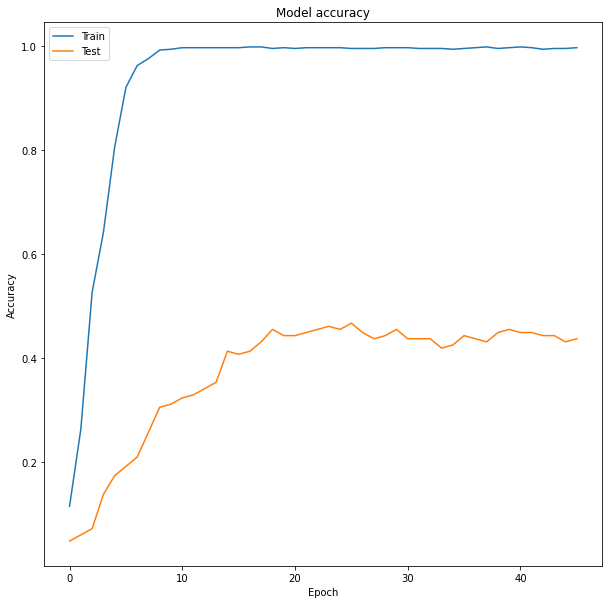

6/6 - 2s - loss: 2.5343 - accuracy: 0.4671


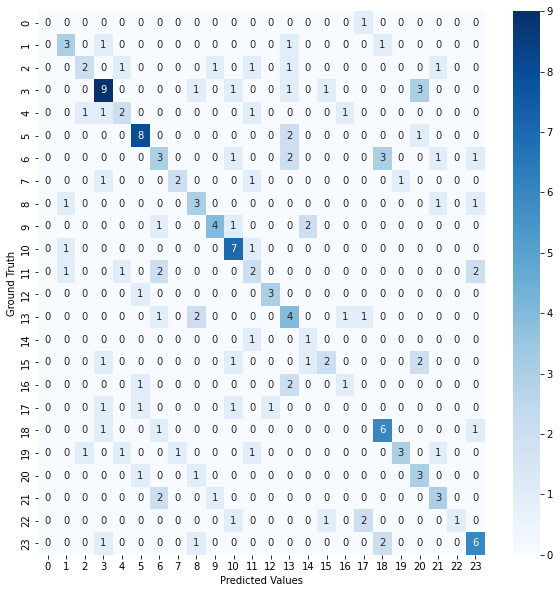


Evaluation accuracy: 46.71 % - loss: 2.53


In [32]:
model = models.Sequential()
model.add(layers.Conv2D(24, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same', input_shape=(144,150,1)))# input_shape=(144,150,1)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.AveragePooling2D(pool_size = (1,12)))
model.add(layers.Flatten())

model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining")

callback = [callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) , callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
history = model.fit(dataset[:n,:,:], target[:n], epochs=100,verbose=1,validation_data = (dataset[n+1:,:,:], target[n+1:]),callbacks=callback)

print("\nModel Trained, Evaluation: \n")
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(dataset[n+1:,:,:], target[n+1:], verbose=2)

if True:
  y_pred = model.predict(dataset[n+1:,:,:])
  matrix = sklearn.metrics.confusion_matrix(keras.utils.to_categorical(target[n+1:]).argmax(axis=1), y_pred.argmax(axis=1))
  figure = plt.figure(figsize=(10, 10))
  import seaborn as sns
  sns.heatmap(matrix, annot=True, cmap = plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('Ground Truth')
  plt.show()

print('\nEvaluation accuracy: %.2f %% - loss: %.2f' % (acc*100, loss))
